In [1]:
# Loading the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import VGG16
from keras.models import Model
from keras.layers import GlobalAveragePooling2D

In [2]:
# Loading the dataset and preparing it for training
train_path = '../archive/seg_train/seg_train/'
test_path = '../archive/seg_test/seg_test/'

# Loading the dataset
import os
import cv2
from tqdm import tqdm

def load_images(path):

    X = []
    y = []

    for folder in os.listdir(path):
        files = os.listdir(path + folder)
        for file in tqdm(files):
            img = cv2.imread(path + folder + '/' + file)
            img = cv2.resize(img, (150, 150))
            X.append(img)
            y.append(folder)
    
    X = np.array(X)
    y = np.array(y)

    return X, y

X_train, y_train = load_images(train_path)
X_test, y_test = load_images(test_path)

classes_names = np.unique(y_train)

# Encoding the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# One hot encoding the target variable
y_train_encoded = to_categorical(y_train_encoded)
y_test_encoded = to_categorical(y_test_encoded)

# Splitting the training set into training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_encoded, test_size=0.2, random_state=0)

# Normalizing the images
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

100%|██████████| 510/510 [00:00<00:00, 2294.45it/s]


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Training the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Saving the model
model.save('vgg16_model.h5')

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [3]:
# Loading the model and evaluating it on the test set
from keras.models import load_model

model = load_model('vgg16_model.h5')

test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
predictions = model.predict(X_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

2024-06-16 10:16:29.438849: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


94/94 [==============================] - 130s 1s/step
Test Loss: 0.3255618214607239
Test Accuracy: 0.878333330154419


F1 Score:  0.8772978235738141
Precision:  0.88028856781749
Recall:  0.8783333333333333
Accuracy:  0.8783333333333333


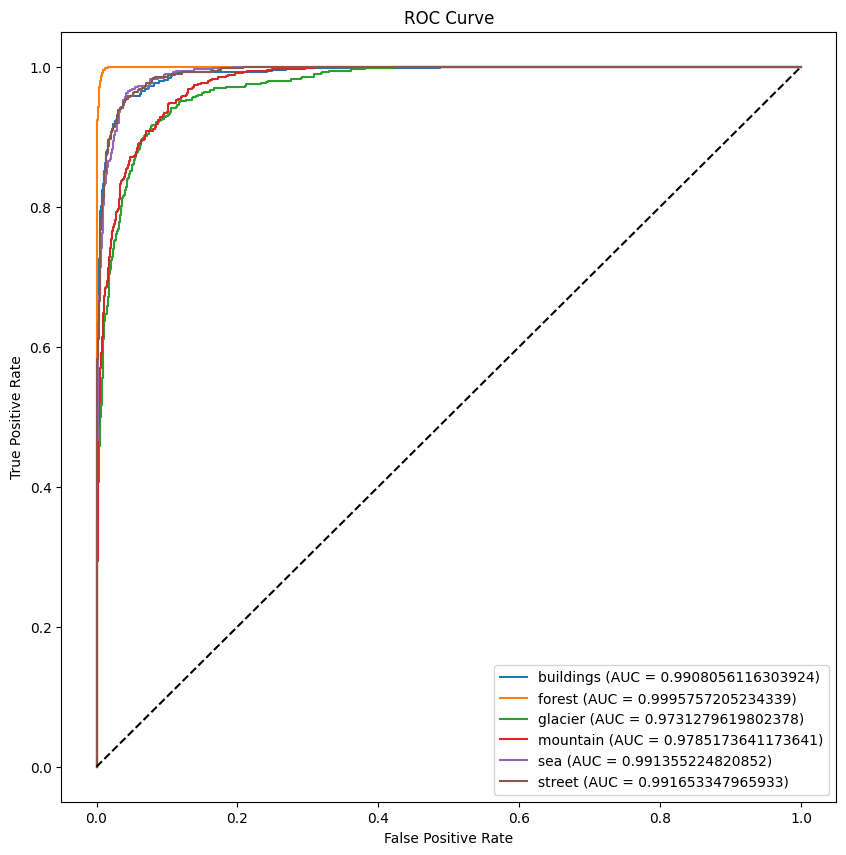

              precision    recall  f1-score   support

   buildings       0.89      0.90      0.89       437
      forest       0.97      0.99      0.98       474
     glacier       0.88      0.73      0.80       553
    mountain       0.79      0.87      0.83       525
         sea       0.86      0.93      0.89       510
      street       0.91      0.88      0.90       501

    accuracy                           0.88      3000
   macro avg       0.88      0.88      0.88      3000
weighted avg       0.88      0.88      0.88      3000



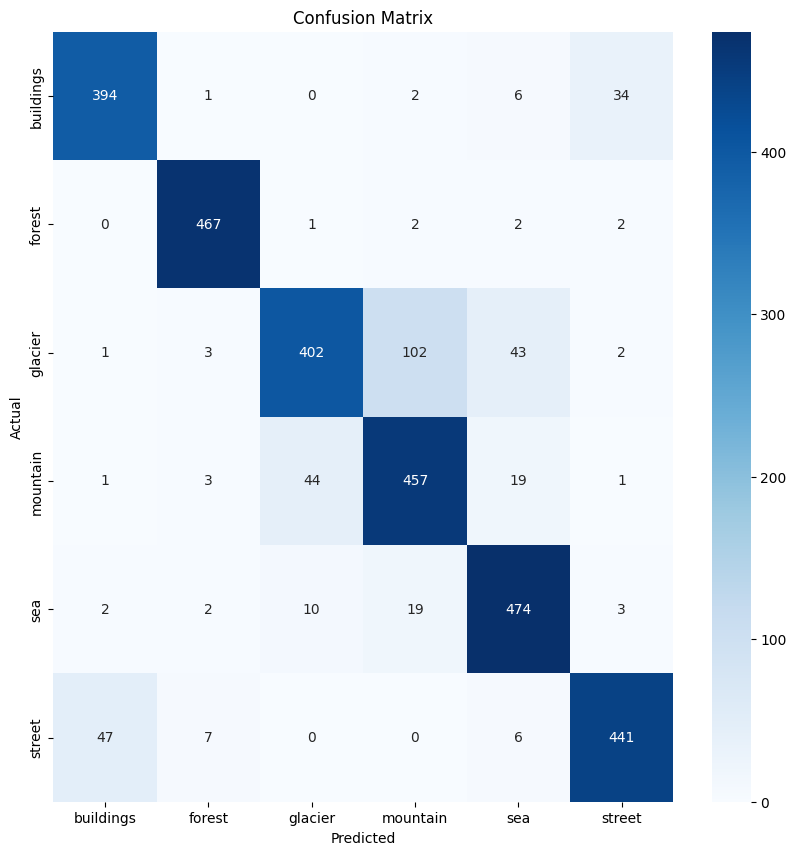

In [4]:
# Model Evaluation

# f1 score, precision, recall, accuracy, confusion matrix, classification report, and ROC curve

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_curve, auc

# F1 Score
f1 = f1_score(np.argmax(y_test_encoded, axis=1), np.argmax(predictions, axis=1), average='weighted')
print("F1 Score: ", f1)

# Precision
precision = precision_score(np.argmax(y_test_encoded, axis=1), np.argmax(predictions, axis=1), average='weighted')
print("Precision: ", precision)

# Recall
recall = recall_score(np.argmax(y_test_encoded, axis=1), np.argmax(predictions, axis=1), average='weighted')
print("Recall: ", recall)

# Accuracy
accuracy = accuracy_score(np.argmax(y_test_encoded, axis=1), np.argmax(predictions, axis=1))
print("Accuracy: ", accuracy)

# ROC Curve
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(y_test_encoded[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 10))

for i in range(6):
    plt.plot(fpr[i], tpr[i], label=classes_names[i] + ' (AUC = ' + str(roc_auc[i]) + ')')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')
plt.show()

# Classification Report
from sklearn.metrics import classification_report

print(classification_report(np.argmax(y_test_encoded, axis=1), np.argmax(predictions, axis=1), target_names=classes_names))

# Confusion Matrix
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(np.argmax(y_test_encoded, axis=1), np.argmax(predictions, axis=1))

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes_names, yticklabels=classes_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


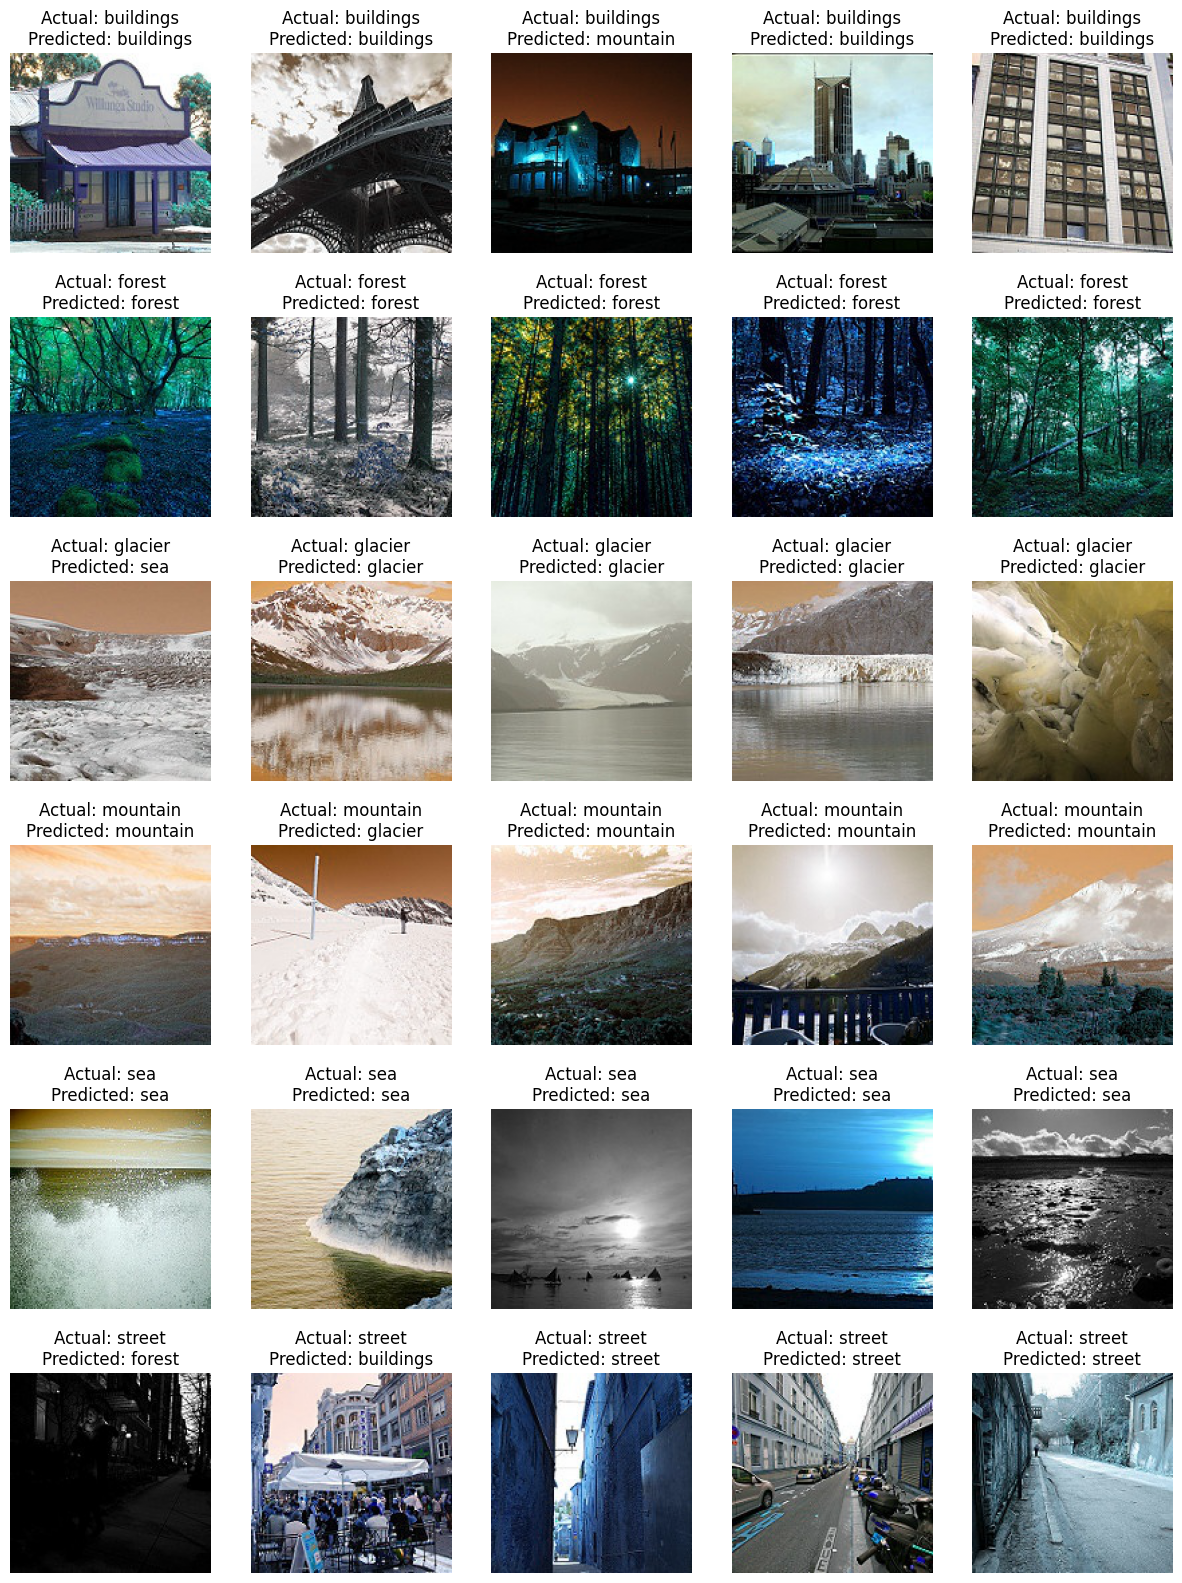

In [5]:
# Function to displaying random predictions from the dataset with their images and predictions

def display_random_predictions(X, y, predictions, classes_names, number_of_predictions=5):
    plt.figure(figsize=(15, 20))

    for class_name in classes_names:
        for i in range(number_of_predictions):
            index = np.random.choice(np.where(y == class_name)[0])
            plt.subplot(len(classes_names), number_of_predictions, number_of_predictions * list(classes_names).index(class_name) + i + 1)
            plt.imshow(X[index])
            plt.title("Actual: " + class_name + "\nPredicted: " + label_encoder.classes_[np.argmax(predictions[index])])
            plt.axis('off')
    
    plt.show()

display_random_predictions(X_test, y_test, predictions, classes_names)